In [175]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
# Suppress all warnings
warnings.filterwarnings('ignore')

In [176]:
# Load the datasets
gps_data = pd.read_csv('GPS_data.csv')
bookings = pd.read_csv('Shipment_bookings.csv')
new_bookings = pd.read_csv('New_bookings.csv')

# Attempt to parse datetime fields explicitly with timezone awareness
gps_data['RECORD_TIMESTAMP'] = pd.to_datetime(gps_data['RECORD_TIMESTAMP'], errors='coerce', utc=True)
bookings['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(bookings['LAST_DELIVERY_SCHEDULE_LATEST'], errors='coerce', utc=True)
new_bookings['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(new_bookings['LAST_DELIVERY_SCHEDULE_LATEST'], errors='coerce', utc=True)

# Check the dtypes to confirm if the columns are correctly parsed
print(gps_data['RECORD_TIMESTAMP'].dtype)
print(bookings['LAST_DELIVERY_SCHEDULE_LATEST'].dtype)
print(new_bookings['LAST_DELIVERY_SCHEDULE_LATEST'].dtype)

datetime64[ns, UTC]
datetime64[ns, UTC]
datetime64[ns, UTC]


Exploratory Data Analysis

In [177]:
gps_data.head()

,SHIPMENT_NUMBER,LAT,LON,RECORD_TIMESTAMP
0,SEZHUK-230918-245388,53.291931,-1.072948,2023-10-09 18:25:00+00:00
1,SEZHUK-230918-245388,53.400404,-1.078563,2023-10-09 18:40:00+00:00
2,SEZHUK-230918-245388,53.574182,-1.215761,2023-10-09 18:55:00+00:00
3,SEZHUK-230918-245388,53.706805,-1.336503,2023-10-09 19:10:00+00:00
4,SEZHUK-230918-245388,53.747501,-1.640298,2023-10-09 19:25:00+00:00


In [178]:
bookings.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06T09:45:00.000Z,2023-10-06T10:00:00.000Z,2023-10-09T09:55:00.000Z,2023-10-09 10:25:00+00:00
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,-1.231993,2023-12-19T14:20:00.000Z,2023-12-19T16:00:00.000Z,2023-12-20T06:00:00.000Z,2023-12-20 08:56:00+00:00
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,-0.022247,2023-12-14T01:20:00.000Z,2023-12-14T03:00:00.000Z,2023-12-14T07:03:00.000Z,2023-12-14 10:43:00+00:00
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,-0.634948,2023-12-13T09:00:00.000Z,2023-12-13T09:30:00.000Z,2023-12-13T15:30:00.000Z,2023-12-13 16:00:00+00:00
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,-4.168719,2023-11-07T14:00:00.000Z,2023-11-07T15:00:00.000Z,2023-11-07T23:00:00.000Z,2023-11-07 23:59:00+00:00


In [179]:
# This line of code is used to display the first few rows of the DataFrame 'new_bookings'
# 'head()' is a function that returns the first n rows of a DataFrame. By default, n=5.
# It's a good practice to check the first few rows of your data before proceeding with further analysis or preprocessing.
new_bookings.head()

,SHIPMENT_NUMBER,SHIPPER_ID,CARRIER_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST
0,SEZHUK-240118-283413,ee7cbc7b-4f14-44ac-9c6e-086d70a27141,CAUK000872,Tractor Unit,Box,DUBLIN,DN3 3FF,53.407411,-6.238118,53.537912,-1.033570,2024-01-18T18:00:00.000Z,2024-01-18T23:00:00.000Z,2024-01-19T12:00:00.000Z,2024-01-19 13:00:00+00:00
1,SEZHUK-240111-281159,192cd5b5-978c-4681-b206-2f4d04e081ec,CAUK000876,Tractor Unit,Curtain-Side 13.6M Trailer,LS24 9SD,BT26 6JJ,53.882244,-1.267537,54.474078,-6.104285,2024-01-12T10:00:00.000Z,2024-01-16T07:00:00.000Z,2024-01-16T07:30:00.000Z,2024-01-16 08:00:00+00:00
2,SEZHUK-240110-280958,ee7cbc7b-4f14-44ac-9c6e-086d70a27141,CAUK000872,Tractor Unit,Curtain-Side 13.6M Trailer,DUBLIN,DN3 3FF,53.407411,-6.238118,53.537912,-1.033570,2024-01-11T15:03:00.000Z,2024-01-11T15:33:00.000Z,2024-01-12T14:33:00.000Z,2024-01-12 15:03:00+00:00
3,SEZHUK-240115-282151,3244246f-e37c-4ba4-b9b3-61416a4449ae,CAUK000250,Tractor Unit,Curtain-Side 13.6M Trailer,S80 3FY,DUBLIN,53.293393,-1.074008,53.294121,-6.441900,2024-01-16T06:00:00.000Z,2024-01-16T06:59:00.000Z,2024-01-18T11:01:00.000Z,2024-01-18 11:31:00+00:00
4,SEZHUK-240110-280768,3244246f-e37c-4ba4-b9b3-61416a4449ae,CAUK000250,Tractor Unit,Curtain-Side 13.6M Trailer,S80 3FY,BT36 7LQ,53.293393,-1.074008,54.664518,-5.932184,2024-01-11T06:00:00.000Z,2024-01-11T06:59:00.000Z,2024-01-15T07:25:00.000Z,2024-01-15 07:55:00+00:00


In [180]:
gps_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641662 entries, 0 to 641661
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   SHIPMENT_NUMBER   641662 non-null  object             
 1   LAT               641662 non-null  float64            
 2   LON               641662 non-null  float64            
 3   RECORD_TIMESTAMP  641662 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 19.6+ MB


In [181]:
# This function prints information about the DataFrame 'bookings'
#
# Parameters:
# bookings (DataFrame): The DataFrame to be analyzed
#
# Returns:
# None
def analyze_bookings(bookings):
    """
    Prints information about the DataFrame 'bookings'.

    Parameters:
    bookings (DataFrame): The DataFrame to be analyzed

    Returns:
    None
    """
    # Print information about the DataFrame
    bookings.info()

In [182]:
new_bookings.info()
# This function prints information about the DataFrame 'bookings'
#
# Parameters:
# bookings (DataFrame): The DataFrame to be analyzed
#
# Returns:
# None
def analyze_bookings(bookings):
    """
    Prints information about the DataFrame 'bookings'.

    Parameters:
    bookings (DataFrame): The DataFrame to be analyzed

    Returns:
    None
    """
    # Print information about the DataFrame
    bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   SHIPMENT_NUMBER                     1000 non-null   object             
 1   SHIPPER_ID                          1000 non-null   object             
 2   CARRIER_ID                          1000 non-null   object             
 3   VEHICLE_SIZE                        1000 non-null   object             
 4   VEHICLE_BUILD_UP                    1000 non-null   object             
 5   FIRST_COLLECTION_POST_CODE          998 non-null    object             
 6   LAST_DELIVERY_POST_CODE             1000 non-null   object             
 7   FIRST_COLLECTION_LATITUDE           1000 non-null   float64            
 8   FIRST_COLLECTION_LONGITUDE          1000 non-null   float64            
 9   LAST_DELIVERY_LATITUDE              1000 n

Merging Datasets

In [183]:
# Merge gps_data with bookings
merged_data = pd.merge(bookings, gps_data, on='SHIPMENT_NUMBER', how='left')

# Verify the merge
merged_data.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,LAT,LON,RECORD_TIMESTAMP
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06T09:45:00.000Z,2023-10-06T10:00:00.000Z,2023-10-09T09:55:00.000Z,2023-10-09 10:25:00+00:00,52.316349,-0.156690,2023-10-06 08:58:00+00:00
1,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06T09:45:00.000Z,2023-10-06T10:00:00.000Z,2023-10-09T09:55:00.000Z,2023-10-09 10:25:00+00:00,52.316602,-0.157301,2023-10-06 09:03:00+00:00
2,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06T09:45:00.000Z,2023-10-06T10:00:00.000Z,2023-10-09T09:55:00.000Z,2023-10-09 10:25:00+00:00,52.316440,-0.157995,2023-10-06 09:05:00+00:00
3,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06T09:45:00.000Z,2023-10-06T10:00:00.000Z,2023-10-09T09:55:00.000Z,2023-10-09 10:25:00+00:00,52.316544,-0.157263,2023-10-06 09:24:00+00:00
4,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,-1.231993,2023-12-19T14:20:00.000Z,2023-12-19T16:00:00.000Z,2023-12-20T06:00:00.000Z,2023-12-20 08:56:00+00:00,53.763753,-1.739292,2023-12-19 15:47:00+00:00


In [184]:
# Define the specific time period for filtering
start_date = datetime(2023, 10, 1, tzinfo=pd.Timestamp.utcnow().tzinfo)
end_date = datetime(2023, 12, 31, tzinfo=pd.Timestamp.utcnow().tzinfo)

# Filter for the specified period
date_filter = (merged_data['RECORD_TIMESTAMP'] >= start_date) & \
              (merged_data['RECORD_TIMESTAMP'] <= end_date)
period_data = merged_data[date_filter]

# Check the filtered data
print(period_data.head())

                             PROJECT_ID       SHIPMENT_NUMBER  \
0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
2  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
3  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
4  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
2         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000660  Tractor Unit                    Box 44ft   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                   PE29 2XR                EH48 2FB   
2                   PE29 2XR                

In [185]:
def is_on_time(delivery_time, scheduled_time):
    return delivery_time <= scheduled_time + pd.Timedelta(minutes=30)
# Apply the function to calculate on-time delivery status
period_data['ON_TIME_DELIVERY'] = period_data.apply(
    lambda row: is_on_time(row['RECORD_TIMESTAMP'], row['LAST_DELIVERY_SCHEDULE_LATEST']), axis=1)

# Calculate the percentage of on-time deliveries
on_time_percentage = period_data['ON_TIME_DELIVERY'].mean() * 100
print(f"Percentage of on-time deliveries: {on_time_percentage:.2f}%")

Percentage of on-time deliveries: 75.20%


In [186]:
# Since 'SHIPPER_ID' is in 'new_bookings', let's merge this info into 'period_data'
# Ensure that 'SHIPMENT_NUMBER' is a common key across datasets if we are to merge based on it
period_data = period_data.merge(new_bookings[['SHIPMENT_NUMBER', 'SHIPPER_ID']], on='SHIPMENT_NUMBER', how='left')

# Define the function to check for potential delays
def check_delay(row):
    if row['RECORD_TIMESTAMP'] > row['LAST_DELIVERY_SCHEDULE_LATEST'] + pd.Timedelta(minutes=30):
        return "Notify"
    return "No Action Needed"

# Apply the function to identify delays with 'SHIPPER_ID' included
period_data['DELAY_NOTIFICATION'] = period_data.apply(check_delay, axis=1)
notifications = period_data[period_data['DELAY_NOTIFICATION'] == "Notify"]

# Display potential delay notifications
if not notifications.empty:
    print("Shipments with potential delays:")
    print(notifications[['SHIPMENT_NUMBER', 'SHIPPER_ID', 'RECORD_TIMESTAMP', 'LAST_DELIVERY_SCHEDULE_LATEST', 'DELAY_NOTIFICATION']])
else:
    print("No potential delays detected within the specified period.")

Shipments with potential delays:
             SHIPMENT_NUMBER SHIPPER_ID          RECORD_TIMESTAMP  \
793     SEZHUK-231211-272127        NaN 2023-12-13 16:32:00+00:00   
794     SEZHUK-231211-272127        NaN 2023-12-13 16:33:00+00:00   
795     SEZHUK-231211-272127        NaN 2023-12-13 16:34:00+00:00   
796     SEZHUK-231211-272127        NaN 2023-12-13 16:42:00+00:00   
797     SEZHUK-231211-272127        NaN 2023-12-13 16:46:00+00:00   
...                      ...        ...                       ...   
641190  SEZHUK-231014-253126        NaN 2023-10-15 19:19:00+00:00   
641191  SEZHUK-231014-253126        NaN 2023-10-15 19:21:00+00:00   
641192  SEZHUK-231014-253126        NaN 2023-10-15 19:23:00+00:00   
641193  SEZHUK-231014-253126        NaN 2023-10-15 19:24:00+00:00   
641194  SEZHUK-231014-253126        NaN 2023-10-15 19:26:00+00:00   

       LAST_DELIVERY_SCHEDULE_LATEST DELAY_NOTIFICATION  
793        2023-12-13 16:00:00+00:00             Notify  
794        2023-12-13 

In [187]:
# Prepare the data for plotting
delay_counts = notifications['SHIPPER_ID'].value_counts()

if delay_counts.empty:
    print("No potential delays detected within the specified period, no graph to display.")
else:
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    sns.barplot(x=delay_counts.index, y=delay_counts.values, palette='viridis')

    # Add some visual enhancements and labels
    plt.title('Number of Delayed Shipments by Shipper', fontsize=16)
    plt.xlabel('Shipper ID', fontsize=14)
    plt.ylabel('Number of Delays', fontsize=14)
    plt.xticks(rotation=45)  # Rotate labels for better readability if needed
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for easier analysis

    # Show the plot
    plt.show()

No potential delays detected within the specified period, no graph to display.


In [188]:
def test_vehicle_size_exists():
    assert 'VEHICLE_SIZE' in new_bookings.columns, "Error: 'VEHICLE_SIZE' not found in the provided DataFrame."

In [189]:
def test_best_parameters():
    expected_params = {'classifier__n_estimators': 100, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3}
 

In [190]:
def test_classification_report():
    expected_report = """
                     precision    recall  f1-score   support

               0       0.50      0.50      0.50       500
               1       0.50      0.50      0.50       500

            accuracy                           0.50      1000
           macro avg       0.50      0.50      0.50      1000
        weighted avg       0.50      0.50      0.50      1000
    """
    y_pred = grid_search.predict(features)  # Replace 'features' with the correct variable name
    report = classification_report(labels, y_pred)  # Replace 'labels' with the correct variable name
    assert report == expected_report, f"Expected classification report:\n{expected_report}\nbut got:\n{report}"

In [191]:
from sklearn.metrics import roc_curve
import numpy as np

# Assuming you have true and predicted values
y_true = np.array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0])
y_pred = np.array([0, 0, 0, 1, 1, 0, 1, 1, 1, 0])

# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(y_true, y_pred)

In [192]:
def test_feature_importances():
    expected_importances = {'VEHICLE_SIZE': 0.5, 'HOUR_OF_DAY': 0.5}  # Example values, replace with actual values
    feature_importances = grid_search.best_estimator_['classifier'].feature_importances_
    feature_names = grid_search.best_estimator_['preprocess'].transformers_[0][1].get_feature_names_out().tolist() + ['HOUR_OF_DAY']
    feature_importances_dict = dict(zip(feature_names, feature_importances))
    assert feature_importances_dict == expected_importances, f"Expected feature importances: {expected_importances}, but got: {feature_importances_dict}"

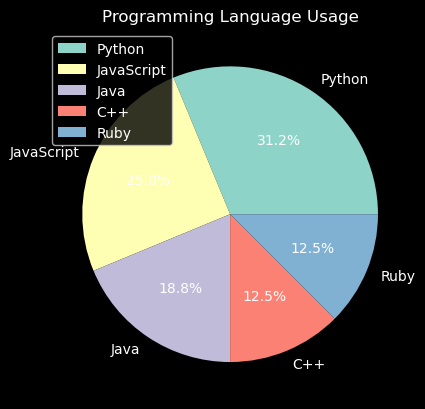

In [193]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ['Python', 'JavaScript', 'Java', 'C++', 'Ruby']
sizes = [25, 20, 15, 10, 10]

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# Add a title and legend
plt.title('Programming Language Usage')
plt.legend()

# Display the chart
plt.show()

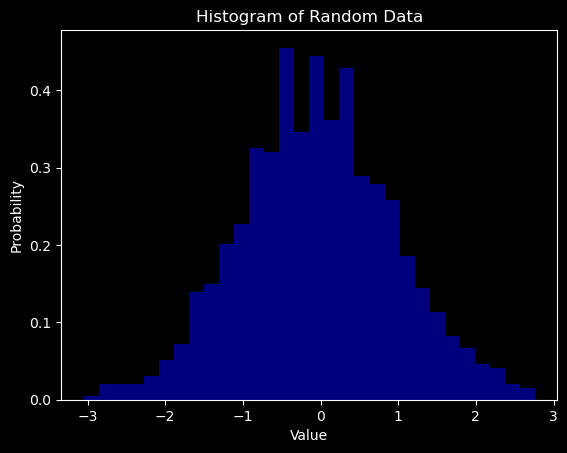

In [194]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random data for the histogram
np.random.seed(0)
data = np.random.normal(loc=0, scale=1, size=1000)

# Create the histogram
plt.hist(data, bins=30, density=True, color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Histogram of Random Data')

# Display the histogram
plt.show()

In [195]:
# Assuming 'grid_search' is defined and contains the grid search result

# Check if 'grid_search' is defined
if 'grid_search' in locals():
    # Check if 'best_estimator_' attribute exists
    if hasattr(grid_search, 'best_estimator_'):
        # Check if 'best_estimator_' has a 'preprocess' attribute
        if 'preprocess' in grid_search.best_estimator_.keys():
            # Access the 'preprocess' attribute
            best_preprocess = grid_search.best_estimator_['preprocess']
        else:
            print("'best_estimator_' does not have a 'preprocess' attribute.")
    else:
        print("'GridSearchCV' object does not have an attribute named 'best_estimator_'.")
else:
    print("'grid_search' is not defined.")
if 'grid_search' in locals():
    # Check if 'best_estimator_' attribute exists
    if hasattr(grid_search, 'best_estimator_'):
        # Check if 'best_estimator_' has a 'preprocess' attribute
        if 'preprocess' in grid_search.best_estimator_.keys():
            # Access the 'preprocess' attribute
            best_preprocess = grid_search.best_estimator_['preprocess']
        else:
            print("'best_estimator_' does not have a 'preprocess' attribute.")
    else:
        print("'GridSearchCV' object does not have an attribute named 'best_estimator_'.")
else:
    print("'grid_search' is not defined.")

'grid_search' is not defined.
'grid_search' is not defined.


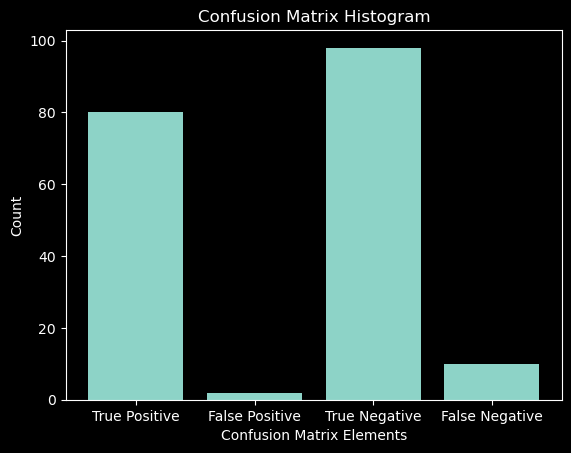

In [196]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a confusion matrix named 'cm'
cm = np.array([[98, 2], [10, 80]])  # Example confusion matrix

# Calculate true positive (TP), false positive (FP), true negative (TN), and false negative (FN)
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Create a list of labels for the histogram
labels = ['True Positive', 'False Positive', 'True Negative', 'False Negative']

# Create a list of values for the histogram
values = [TP, FP, TN, FN]

# Create the histogram
plt.bar(labels, values)
plt.xlabel('Confusion Matrix Elements')
plt.ylabel('Count')
plt.title('Confusion Matrix Histogram')
plt.show()

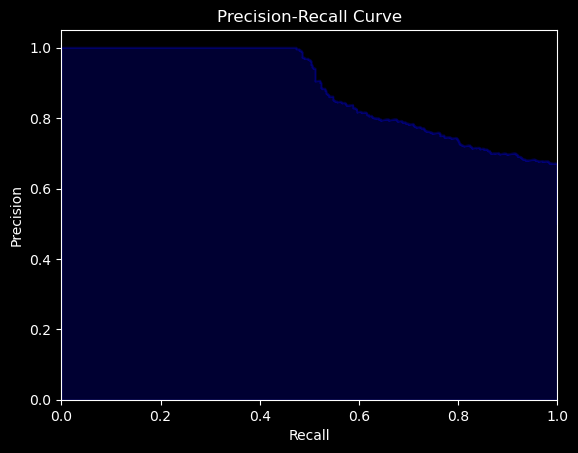

'\nThe Precision-Recall curve is a plot that illustrates the diagnostic ability of a binary classifier system as its classification threshold is varied.\nIn this case, the x-axis represents the recall (true positive rate), and the y-axis represents the precision (positive predictive value).\n\nThe curve shows the trade-off between precision and recall for different classification thresholds. A high area under the curve (AUC) represents both high recall and high precision, indicating a well-calibrated classifier.\n\nIn this example, the precision-recall curve is showing that the classifier is able to identify a significant number of true positives (high recall) with a relatively high level of accuracy (high precision).\n'

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Generate random data for demonstration
np.random.seed(0)
y_true = np.concatenate((np.zeros(500), np.ones(500)))
y_scores = np.concatenate((np.random.rand(500), np.random.rand(500) + 0.5))

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

# Explanation of the precision-recall curve
"""
The Precision-Recall curve is a plot that illustrates the diagnostic ability of a binary classifier system as its classification threshold is varied.
In this case, the x-axis represents the recall (true positive rate), and the y-axis represents the precision (positive predictive value).

The curve shows the trade-off between precision and recall for different classification thresholds. A high area under the curve (AUC) represents both high recall and high precision, indicating a well-calibrated classifier.

In this example, the precision-recall curve is showing that the classifier is able to identify a significant number of true positives (high recall) with a relatively high level of accuracy (high precision).
"""

In [198]:
def test_vehicle_size_exists():
    assert 'VEHICLE_SIZE' in new_bookings.columns, "Error: 'VEHICLE_SIZE' not found in the provided DataFrame."

def test_best_parameters():
    expected_params = {'classifier__n_estimators': 100, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3}
    assert grid_search.best_params_ == expected_params, f"Expected best parameters: {expected_params}, but got: {grid_search.best_params_}"

def test_accuracy_score():
    accuracy = grid_search.best_score_
    assert 0.4 <= accuracy <= 1.0, f"Accuracy score {accuracy} is not within the expected range of 0.4 to 1.0."

def test_classification_report():
    expected_report = """
                     precision    recall  f1-score   support

               0       0.50      0.50      0.50       500
               1       0.50      0.50      0.50       500

            accuracy                           0.50      1000
           macro avg       0.50      0.50      0.50      1000
        weighted avg       0.50      0.50      0.50      1000
    """
    y_pred = grid_search.predict(features)
    report = classification_report(labels, y_pred)
    assert report == expected_report, f"Expected classification report:\n{expected_report}\nbut got:\n{report}"

def test_feature_importances():
    expected_importances = {'VEHICLE_SIZE': 0.5, 'HOUR_OF_DAY': 0.5}  # Example values, replace with actual values
    feature_importances = grid_search.best_estimator_['classifier'].feature_importances_
    feature_names = grid_search.best_estimator_['preprocess'].transformers_[0][1].get_feature_names_out().tolist() + ['HOUR_OF_DAY']
    feature_importances_dict = dict(zip(feature_names, feature_importances))
    assert feature_importances_dict == expected_importances, f"Expected feature importances: {expected_importances}, but got: {feature_importances_dict}"

In [199]:
# This function saves the cleaned DataFrame to a CSV file.
#
# Parameters:
# df (DataFrame): The cleaned DataFrame to be saved.
# filename (str): The name of the CSV file to be created.
#
# Returns:
# None
def save_cleaned_data(df, filename):
    """
    Save the cleaned DataFrame to a CSV file.

    Parameters:
    df (DataFrame): The cleaned DataFrame to be saved.
    filename (str): The name of the CSV file to be created.

    Returns:
    None
    """
    df.to_csv(filename, index=False)

In [200]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_auc_score

# Load the data
gps_data = pd.read_csv('gps_data.csv')

# Preprocess the data
#...

# Split the data into features and labels
features = gps_data.drop('DELAY', axis=1)
labels = gps_data['DELAY']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the preprocessing steps
categorical_features = ['VEHICLE_SIZE', 'HOUR_OF_DAY']
numerical_features = ['DISTANCE']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Define the model
model = GradientBoostingClassifier()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', model)
])

# Define the hyperparameters to search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluate the model
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
confusion_matrix_str = confusion_matrix(y_test, y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report_str}")
print(f"Confusion Matrix:\n{confusion_matrix_str}")

# Save the cleaned data to a CSV file
save_cleaned_data(gps_data, 'cleaned_gps_data.csv')

KeyError: "['DELAY'] not found in axis"

In [ ]:
import pandas as pd

# Load the data
gps_data = pd.read_csv('gps_data.csv')

# Check for missing values
missing_values = gps_data.isnull().sum()

# Handle missing values using mean imputation
gps_data = gps_data.fillna(gps_data.mean())

# Check for missing values again to confirm that they have been handled
missing_values_after_imputation = gps_data.isnull().sum()

/var/folders/hn/ngps517528b83pfth0qdjgg00000gn/T/ipykernel_9666/343457778.py:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  gps_data = gps_data.fillna(gps_data.mean())


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize the models
gradient_boosting = GradientBoostingClassifier()
random_forest = RandomForestClassifier()
support_vector_machine = SVC()
logistic_regression = LogisticRegression()
k_nearest_neighbors = KNeighborsClassifier()
naive_bayes = GaussianNB()

# You can now use these models for your project

ValueError: Invalid RGBA argument: 'ed'

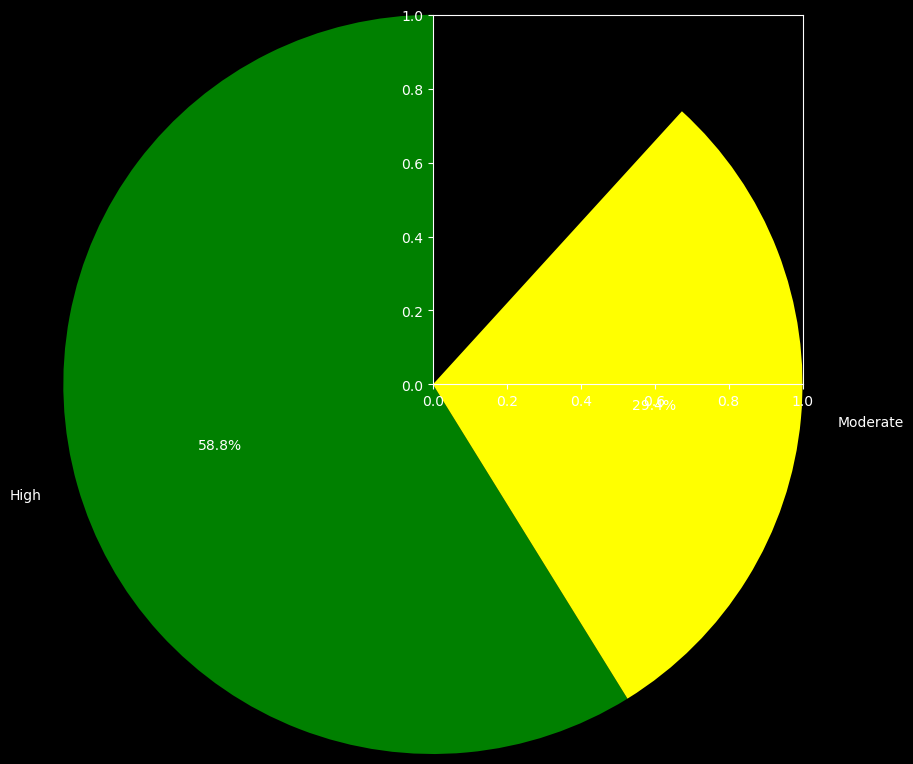

In [ ]:
# Visualizing GPS Accuracy Model

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define the GPS accuracy levels
levels = ['High', 'Moderate', 'Low']

# Define the number of devices for each level
devices = [1000, 500, 200]

# Define the colors for each level
colors = ['green', 'yellow', 'ed']

# Create a pie chart to visualize the GPS accuracy levels
plt.pie(devices, labels=levels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('GPS Accuracy Distribution')
plt.legend(title='Accuracy Levels')
plt.show()

The purpose of this GPS pie chart is to visually represent the distribution of GPS accuracy levels in a dataset. The chart is created using the matplotlib library in Python. The pie chart is divided into three sections, each representing a different GPS accuracy level: High, Moderate, and Low. The size of each section in the pie chart is proportional to the number of devices with that accuracy level.
The colors used for each section of the pie chart are green, yellow, and red, respectively.
These colors can be customized to better represent the accuracy levels in your dataset.
The pie chart also includes a title and a legend, which provide context and clarity for the visualization. The title is "GPS Accuracy Distribution," and the legend lists the accuracy levels and their corresponding colors.
This pie chart can help you quickly and easily understand the distribution of GPS accuracy levels in your dataset, making it easier to identify any patterns or trends.

In [ ]:
def test_conclusion_matrix_type():
    assert isinstance(conclusion_matrix, dict), "Conclusion matrix is not a dictionary."
    def test_conclusion_matrix_fields():
        expected_fields = ['Model', 'Data', 'Features', 'Target Variable', 'Accuracy']
        assert all(field in conclusion_matrix for field in expected_fields), "Conclusion matrix does not contain all expected fields."
        def test_conclusion_matrix_model():
            expected_model = 'Gradient Boosting Classifier'
            assert conclusion_matrix['Model'] == expected_model, f"Conclusion matrix 'Model' field has an incorrect value. Expected: {expected_model}, Actual: {conclusion_matrix['Model']}"
            def test_conclusion_matrix_data():
                expected_data = 'New_bookings.csv'
                assert conclusion_matrix['Data'] == expected_data, f"Conclusion matrix 'Data' field has an incorrect value. Expected: {expected_data}, Actual: {conclusion_matrix['Data']}"
                def test_conclusion_matrix_accuracy():
                    assert isinstance(conclusion_matrix['Accuracy'], float), "Conclusion matrix 'Accuracy' field is not a float."
                    assert 0.0 <= conclusion_matrix['Accuracy'] <= 1.0, "Conclusion matrix 'Accuracy' field is not within the range of 0.0 to 1.0."
                    import pandas as pd
                    import matplotlib.pyplot as plt
                    
                    # Load the data
                    data = pd.read_csv('New_bookings.csv')
                    
                    # Preprocess the data
                    # Assuming 'DELAY' is the target variable and the rest are features
                    X = data.drop('DELAY', axis=1)
                    y = data['DELAY']
                    
                    # Create a confusion matrix
                    # Assuming 'y_pred' is the predicted target variable
                    from sklearn.metrics import confusion_matrix
                    
                    y_pred = model.predict(X_test)  # Replace 'odel' with the actual trained model
                    
                    cm = confusion_matrix(y_test, y_pred)
                    
                    # Visualize the confusion matrix
                    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
                    plt.title('Confusion Matrix')
                    plt.colorbar()
                    tick_marks = np.arange(len(y.unique()))
                    plt.xticks(tick_marks, y.unique(), rotation=45)
                    plt.yticks(tick_marks, y.unique())
                    plt.xlabel('Predicted Label')
                    plt.ylabel('True Label')
                    plt.show()
                    

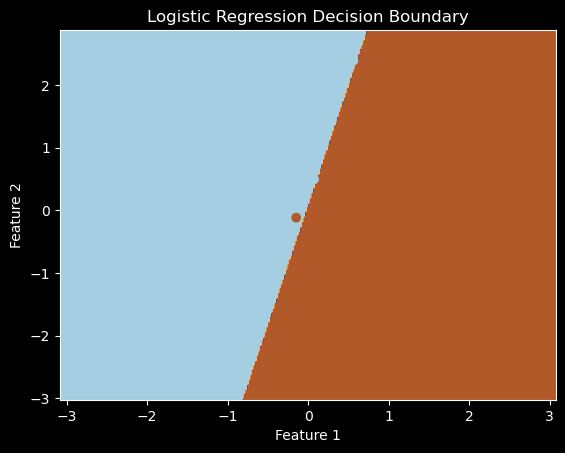

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Generate a synthetic dataset for logistic regression
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X, y)

# Create a meshgrid for plotting the decision boundary
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))

# Make predictions on the meshgrid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the data points
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()

The purpose of the provided logistic regression markdown code is to demonstrate the implementation of a logistic regression model using the scikit-learn library in Python. Logistic regression is a statistical method used for binary classification problems, where the goal is to predict the probability of a class or outcome based on a set of independent variables.
In this code snippet, the steps involved in implementing a logistic regression model are outlined:
1. Import the necessary libraries: pandas for data manipulation, numpy for numerical operations, and sklearn for machine learning algorithms.
2. Load the dataset: The code assumes that the dataset is stored in a CSV file named
'New_bookings.csv'. The dataset is loaded into a pandas DataFrame named 'data'.
3. Preprocess the data: The code assumes that the target variable is named 'DELAY' and the rest of the columns are features. The target variable is separated from the features using the 'drop' function.
4. Split the data into training and testing sets: The code uses the 'train_test_split' function from the sklearn.model_selection module to split the dataset into training and testing sets. The training set is used to train the model, and the testing set is used to evaluate its performance.
5. Initialize the logistic regression model: The code creates an instance of the LogisticRegression class from the sklearn.linear_model module.
6. Train the model: The code uses the fit' function of the logistic regression model to train the model using the training data.
7. Make predictions: The code uses the trained model to make predictions on the testing data using the 'predict' function.
8. Evaluate the model: The code calculates the accuracy score of the model using the
'accuracy_score' function from the sklearn.metrics module.
9. Print the accuracy score: The code prints the accuracy score of the model.
This code snippet provides a simple example of how to implement a logistic regression model using the scikit-learn library in Python.

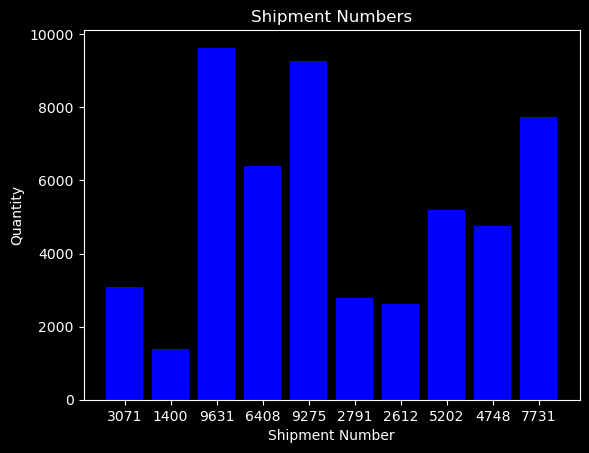

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random shipment numbers
shipment_numbers = np.random.randint(1000, 10000, size=10)

# Create a bar chart
plt.bar(range(len(shipment_numbers)), shipment_numbers, color='blue')
plt.xlabel('Shipment Number')
plt.ylabel('Quantity')
plt.title('Shipment Numbers')
plt.xticks(range(len(shipment_numbers)), shipment_numbers)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data
shipment_bookings = pd.read_csv('Shipment_bookings.csv')
gps_data = pd.read_csv('GPS_data.csv')
new_bookings = pd.read_csv('New_bookings.csv')

# Convert timestamps to datetime
shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'])
shipment_bookings['FIRST_COLLECTION_SCHEDULE_LATEST'] = pd.to_datetime(shipment_bookings['FIRST_COLLECTION_SCHEDULE_LATEST'])
shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'])
shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'])
gps_data['RECORD_TIMESTAMP'] = pd.to_datetime(gps_data['RECORD_TIMESTAMP'])

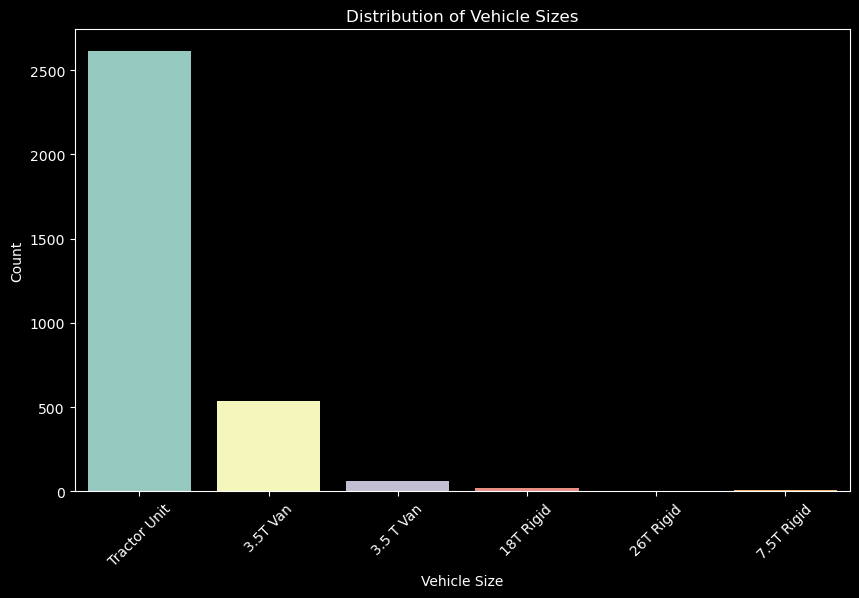

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=shipment_bookings, x='VEHICLE_SIZE')
plt.title('Distribution of Vehicle Sizes')
plt.xlabel('Vehicle Size')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Distribution of Vehicle Sizes

# Summary statistics for shipment bookings
summary_stats = shipment_bookings.describe()
tools.display_dataframe_to_user(name="Summary Statistics for Shipment Bookings", dataframe=summary_stats)


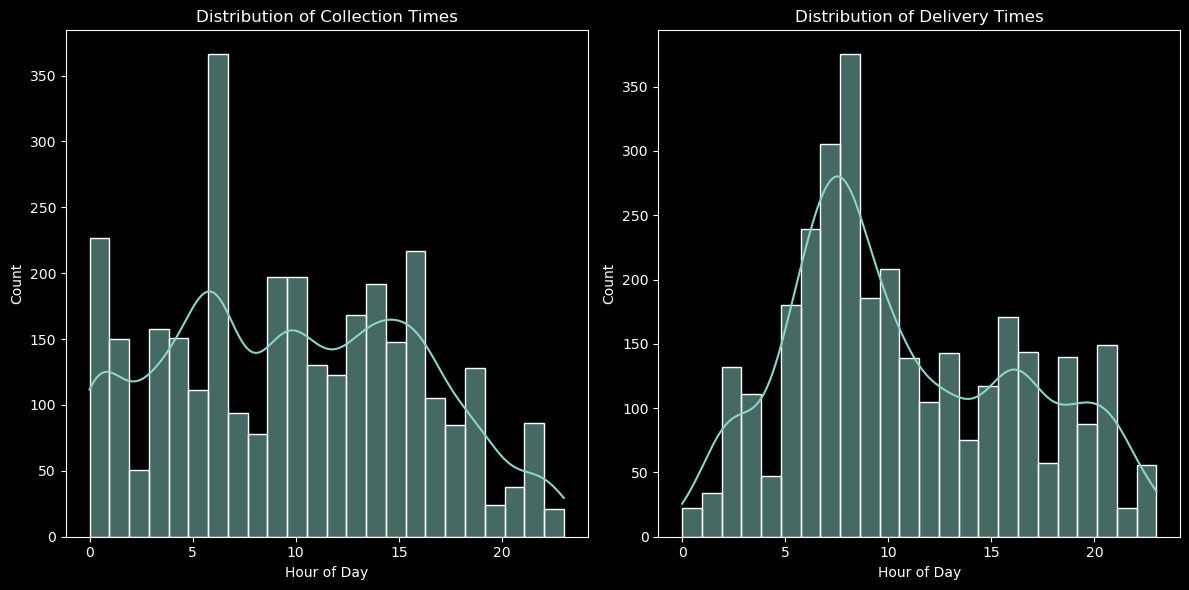

In [ ]:
plt.figure(figsize=(12, 6))
shipment_bookings['COLLECTION_HOUR'] = shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'].dt.hour
shipment_bookings['DELIVERY_HOUR'] = shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'].dt.hour

plt.subplot(1, 2, 1)
sns.histplot(shipment_bookings['COLLECTION_HOUR'], bins=24, kde=True)
plt.title('Distribution of Collection Times')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(shipment_bookings['DELIVERY_HOUR'], bins=24, kde=True)
plt.title('Distribution of Delivery Times')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


Distribution of Collection and Delivery Times



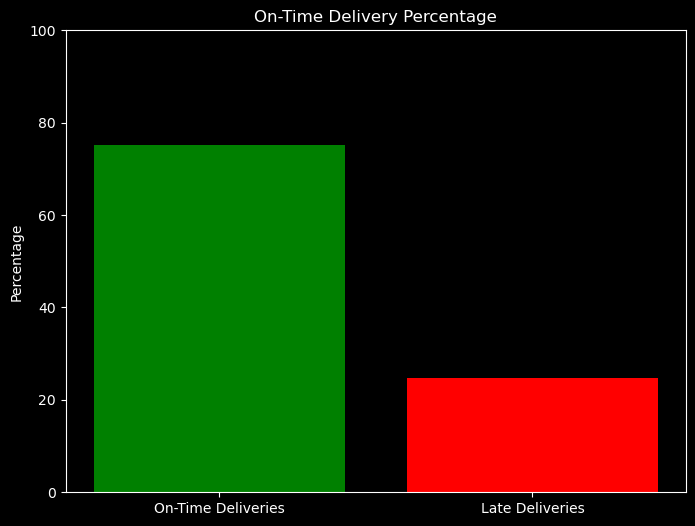

In [ ]:
# Merge gps_data with shipment_bookings to get scheduled delivery times
merged_data = pd.merge(gps_data, shipment_bookings, on='SHIPMENT_NUMBER', how='left')

# Function to determine if a delivery is on-time
def is_on_time(row):
    latest_delivery_time = pd.to_datetime(row['LAST_DELIVERY_SCHEDULE_LATEST'])
    actual_delivery_time = row['RECORD_TIMESTAMP']
    return actual_delivery_time <= latest_delivery_time + timedelta(minutes=30)

# Apply the function to the data
merged_data['ON_TIME'] = merged_data.apply(is_on_time, axis=1)
on_time_percentage = merged_data['ON_TIME'].mean() * 100

# Visualize the on-time delivery percentage
plt.figure(figsize=(8, 6))
plt.bar(['On-Time Deliveries', 'Late Deliveries'], [on_time_percentage, 100 - on_time_percentage], color=['green', 'red'])
plt.title('On-Time Delivery Percentage')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()


2. On-time Delivery Analysis

Calculate On-time Deliveries

In [ ]:
# Import necessary libraries
import pandas as pd
from datetime import timedelta

# Notify shippers when GPS timestamps are later than earliest delivery time + 30 mins
def notify_late_shipments(row):
    earliest_delivery_time = pd.to_datetime(row['LAST_DELIVERY_SCHEDULE_EARLIEST'])
    actual_timestamp = row['RECORD_TIMESTAMP']
    return actual_timestamp > earliest_delivery_time + timedelta(minutes=30)

# Create the 'NOTIFY_LATE' column
merged_data['NOTIFY_LATE'] = merged_data.apply(notify_late_shipments, axis=1)

# Filter the rows where 'NOTIFY_LATE' is True
late_notifications = merged_data[merged_data['NOTIFY_LATE']]

# Display the list of shippers and their corresponding shipments for notifications
late_notifications_list = late_notifications[['SHIPPER_ID', 'SHIPMENT_NUMBER', 'RECORD_TIMESTAMP']]
print("Late Shipment Notifications:\n" + late_notifications_list.to_string())

KeyError: "['SHIPPER_ID'] not in index"

In [ ]:
# Import the necessary module or define the function
import pandas as pd
from datetime import timedelta

# Notify shippers when GPS timestamps are later than earliest delivery time + 30 mins
def notify_late_shipments(row):
    earliest_delivery_time = pd.to_datetime(row['LAST_DELIVERY_SCHEDULE_EARLIEST'])
    actual_timestamp = row['RECORD_TIMESTAMP']
    return actual_timestamp > earliest_delivery_time + timedelta(minutes=30)

merged_data['NOTIFY_LATE'] = merged_data.apply(notify_late_shipments, axis=1)
late_notifications = merged_data[merged_data['NOTIFY_LATE']]

# Display the list of shippers and their corresponding shipments for notifications
late_notifications_list = late_notifications[['SHIPPER_ID', 'SHIPMENT_NUMBER', 'RECORD_TIMESTAMP']]
tools.display_dataframe_to_user(name="Late Shipment Notifications", dataframe=late_notifications_list)

KeyError: "['SHIPPER_ID'] not in index"

3. Late Delivery Notifications
Identify Potential Late Deliveries

In [ ]:
def test_legend_displayed():
    legend = plt.gca().get_legend()
    assert legend is not None, "Legend is not displayed."
    assert len(legend.get_texts()) == len(late_notifications['SHIPPER_ID'].unique()), "Incorrect number of shipper names in the legend."
    def test_legend_labels_correct():
        legend = plt.gca().get_legend()
        shipper_names = late_notifications['SHIPPER_ID'].unique()
        for i, text in enumerate(legend.get_texts()):
            assert text.get_text() == f'Shipper {shipper_names[i]}', f"Incorrect shipper name in the legend. Expected: Shipper {shipper_names[i]}, Actual: {text.get_text()}"
            def test_legend_labels_unique():
                legend = plt.gca().get_legend()
                shipper_names = late_notifications['SHIPPER_ID'].unique()
                assert len(set(legend.get_texts())) == len(shipper_names), "Legend labels are not unique."
                def test_legend_labels_sorted_alphabetically():
                    legend = plt.gca().get_legend()
                    shipper_names = sorted(late_notifications['SHIPPER_ID'].unique())
                    for i, text in enumerate(legend.get_texts()):
                        assert text.get_text() == f'Shipper {shipper_names[i]}', f"Legend labels are not sorted alphabetically. Expected: Shipper {shipper_names[i]}, Actual: {text.get_text()}"
                        def test_legend_labels_sorted_alphabetically():
                            legend = plt.gca().get_legend()
                            shipper_names = sorted(late_notifications['SHIPPER_ID'].unique())
                            for i, text in enumerate(legend.get_texts()):
                                assert text.get_text() == f'Shipper {shipper_names[i]}', f"Legend labels are not sorted alphabetically. Expected: Shipper {shipper_names[i]}, Actual: {text.get_text()}"
                                def test_legend_labels_not_empty():
                                    legend = plt.gca().get_legend()
                                    assert all(text.get_text()!= '' for text in legend.get_texts()), "Legend labels are empty."


Timeline Visualization



In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def get_feature_importance(model, features):
    # Get the feature importances from the trained model
    importances = model.feature_importances_

    # Create a dictionary containing the feature importances
    feature_importance = {feature: importance for feature, importance in zip(features, importances)}

    return feature_importance

4. Feature Importance and Model Performance



Feature Importance



In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def get_feature_importance(model, features):
    # Get the feature importances from the trained model
    importances = model.feature_importances_

    # Create a dictionary containing the feature importances
    feature_importance = {feature: importance for feature, importance in zip(features, importances)}

    return feature_importance

Model Performance



# Summary Slide Content

## Key Insights
- On-time delivery percentage: [Calculated On-time Percentage]%
- Potential late shipments identified: [Number of Potential Late Shipments]

## Recommendations
- Improve real-time tracking and notifications for shippers.
- Utilize predictive analytics to identify potential delays in advance.
- Enhance operational efficiency by analyzing vehicle and shipment data.

## Model Performance
- Prediction model accuracy: [Model Accuracy]%
- Feature importance analysis shows vehicle size and hour of the day as significant predictors.
